# Credit Risk Analysis

### Motivation 
Analyze a retail loan data provided by 'LendingClub', a P2P online loan broker/dealer, and build a prediction model to classify defaulable accounts in advance for a risk management purpose.

### Contents
1. Data Cleaning and Formatting
2. Data Exploration and Engineering
3. Initial Modeling and Evaluation
4. Adding Features
5. Model Comparisons

## Setup

In [1]:
# load packages
from IPython.display import Image
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment',  None)

import re
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# load data
df = pd.read_csv('/Users/llnormll/PycharmProjects/CRA/Dataset/loan.csv', index_col=[0])

/Users/llnormll/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.shape

(887379, 73)

## 1. Data Cleaning and Formatting

There are 74 features in this raw data, and a lot of them have a little usability (mostly filled with NaN values, no varaince, or duplicated to another). So I manually filtered features that I found the most useful.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887379 entries, 1077501 to 36271262
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    887379 non-null  int64  
 1   loan_amnt                    887379 non-null  float64
 2   funded_amnt                  887379 non-null  float64
 3   funded_amnt_inv              887379 non-null  float64
 4   term                         887379 non-null  object 
 5   int_rate                     887379 non-null  float64
 6   installment                  887379 non-null  float64
 7   grade                        887379 non-null  object 
 8   sub_grade                    887379 non-null  object 
 9   emp_title                    835917 non-null  object 
 10  emp_length                   842554 non-null  object 
 11  home_ownership               887379 non-null  object 
 12  annual_inc                   887375 non-null  floa

### 1.1 Initial feature filtering

In [5]:
attribs_to_use = [
    'funded_amnt',          # actual amount funded to loans
    'term',                 # number of payments (month)
    'int_rate',             # interest rate
    'installment',          # monthly payment 
    'sub_grade',            # credit rating
    'emp_length',           # number of years of employment
    'home_ownership',       # home ownership status of each borrower
    'issue_d',              # the month which the loan was funded
    'loan_status',          # current status of the loan (=target variable)
    'purpose',              # purpose of the loan
    'dti',                  # debt to monthly income ratio
    'delinq_2yrs',          # number of 30+ days past-due incidences for last two years
    'earliest_cr_line',     # date each borrower's earliest reported credit line was opened
    'inq_last_6mths',       # number of inquiries in past 6 months
    'total_acc',            # total number of credit lines 
    'pub_rec',              # number of derogatory public records
    'revol_bal',            # total credit revolving balance
    'revol_util',           # total revolving utilization rate 
    'total_rec_late_fee',   # late fees received to date 
    'recoveries',           # post charge off gross recovery
    'last_pymnt_d',         # last month payment was received
    'last_pymnt_amnt',      # last month payment amount
    'last_credit_pull_d',   # the most recent month LC pulled credit for this loan
    'acc_now_delinq',       # number of delinquent accounts
    'total_pymnt'           # total payments received to date
]

df_filter = df[attribs_to_use]
print(df_filter.shape)

(887379, 25)


### 1.2 Format dates

In [6]:
# select date columns
date_columns = [
    'issue_d', 
    'earliest_cr_line', 
    'last_pymnt_d', 
    'last_credit_pull_d'
]

# drop rows containing NaN 
df_filter = df_filter.dropna(subset=date_columns)
df_filter = df_filter.reset_index(drop=True)

# format dates
for col in date_columns:
    df_filter.loc[:, col] = pd.to_datetime(df_filter[col])

df_filter[date_columns].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2011-12-01,1985-01-01,2015-01-01,2016-01-01
1,2011-12-01,1999-04-01,2013-04-01,2013-09-01
2,2011-12-01,2001-11-01,2014-06-01,2016-01-01
3,2011-12-01,1996-02-01,2015-01-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01,2016-01-01


In [7]:
df_filter.isnull().sum()

funded_amnt               0
term                      0
int_rate                  0
installment               0
sub_grade                 0
emp_length            43602
home_ownership            0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
total_acc                 0
pub_rec                   0
revol_bal                 0
revol_util              459
total_rec_late_fee        0
recoveries                0
last_pymnt_d              0
last_pymnt_amnt           0
last_credit_pull_d        0
acc_now_delinq            0
total_pymnt               0
dtype: int64

### 1.3 Format target variable

The `loan_status` is the target variable here containing ten different classes with an imbalanced number of observations. Since this project aims to build a classification model to find defaultable accounts in advance, I divided them into two groups.

In [8]:
df_filter['loan_status'].value_counts()

Current                                                593425
Fully Paid                                             207708
Charged Off                                             44715
Late (31-120 days)                                      11470
In Grace Period                                          6041
Late (16-30 days)                                        2316
Does not meet the credit policy. Status:Fully Paid       1961
Default                                                  1210
Does not meet the credit policy. Status:Charged Off       746
Issued                                                     48
Name: loan_status, dtype: int64

In [9]:
# removed the 'Issued' class since these loans just got approved and have not begun any repayment processes yet
issue = df_filter['loan_status'] == 'Issued'
df_filter_issue = df_filter[~issue]

# binary classification
label_categories = [
    (0, ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 
         'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'])
]

# function to apply the transformation
def classify_label(text):
    for category, matches in label_categories:
        if any(match in text for match in matches):
            return category
    return None

df_filter_issue.loc[:, 'label'] = df_filter_issue['loan_status'].apply(classify_label)
df_filter_issue = df_filter_issue.drop('loan_status', axis=1)

# check label classes imblance
neg, pos = np.bincount(df_filter_issue['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 869592
    Positive: 66498 (7.65% of total)



### 1.4 Customized formatting

> 1.4.1 `home_ownership`

Some of categories in this data only have a few observations (`OTHER`, `NONE`, `ANY`). Simply combine them into one.

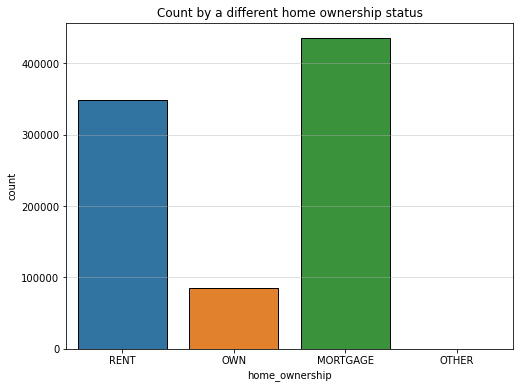

In [146]:
sns.countplot(x='home_ownership', data=df_filter_issue, edgecolor='black')
plt.title('Count by a different home ownership status')
plt.grid(axis='y', alpha=.5)
plt.show()

In [147]:
df_filter_issue['home_ownership'] = df_filter_issue['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

df_filter_issue['home_ownership'].value_counts()

MORTGAGE    434978
RENT        349007
OWN          85377
OTHER          230
Name: home_ownership, dtype: int64

> 1.4.2 `emp_length`


In [148]:
df_filter_issue['emp_length']

0         10
1          0
2         10
3         10
4          1
          ..
869635     8
869636    10
869637     5
869638     1
869639    10
Name: emp_length, Length: 869592, dtype: object

Keep it in a numeric order.

In [61]:
# copy the feature
emp_length = df_filter_issue['emp_length'].copy()

# select not null values only
emp_length_nonull = emp_length.dropna()

# manually replace '< 1 year' to '0'
emp_length_nonull = emp_length_nonull.replace('< 1 year', '0')

# format the rest by removing all strings except for numbers
emp_length_encode = [re.sub('[<years+ ]', '', txt) for txt in emp_length_nonull]

# squeeze back to the original dataset
emp_length[emp_length.notnull()] = np.squeeze(emp_length_encode)
df_filter_issue.loc[:, 'emp_length'] = emp_length

df_filter_issue['emp_length']

0         10
1          0
2         10
3         10
4          1
          ..
869635     8
869636    10
869637     5
869638     1
869639    10
Name: emp_length, Length: 869592, dtype: object

### 1.5 Imputations

In [62]:
mis_vals = df_filter_issue.isnull().sum()

mis_vals[mis_vals > 0]

emp_length    43594
revol_util      459
dtype: int64

> 1.5.1 `emp_length`

Intuitively speaking, an empty value in this data could indicate an unemployment. Before filling it with zeros, I set up some hypotheses and tested them to conclude so.

* Assumptions
  1. Smaller loan amounts would be approved and higher interest rates would be charged to unemployed applicants.
  2. Unemployed invididuals would have lower credit ratings compared to the employed. 

In [63]:
# divide into two categories
df_filter_issue['emp_cat'] = df_filter_issue['emp_length'].apply(lambda x: 'not_employed' if x is np.nan else 'employed')

df_filter_issue['emp_cat'].value_counts()

employed        825998
not_employed     43594
Name: emp_cat, dtype: int64

Text(0.5, 1.0, 'Interest rate')

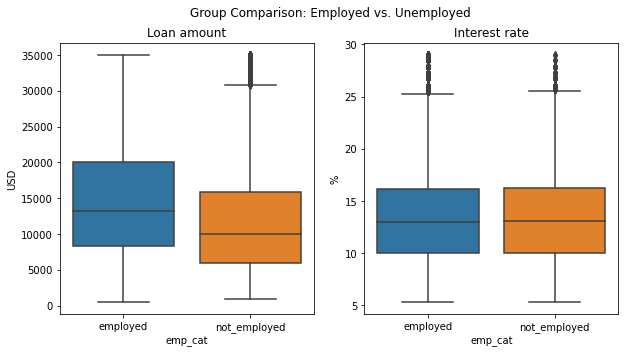

In [64]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Group Comparison: Employed vs. Unemployed')
sns.boxplot(ax=ax[0], x='emp_cat', y='funded_amnt', data=df_filter_issue)
sns.boxplot(ax=ax[1], x='emp_cat', y='int_rate', data=df_filter_issue)
ax[0].set_ylabel('USD')
ax[1].set_ylabel('%')
ax[0].set_title('Loan amount')
ax[1].set_title('Interest rate')

Visually speaking, the two groups have almost identical interest rate range, but differ in their loan amounts. Let's see if the difference is statistically significant.

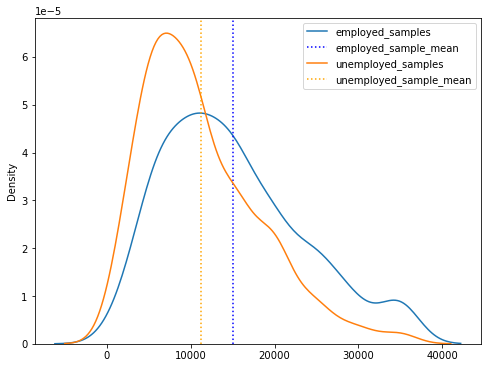

In [65]:
x_emp = df_filter_issue[df_filter_issue['emp_cat'] == 'employed']['funded_amnt'].values
x_noe = df_filter_issue[df_filter_issue['emp_cat'] != 'employed']['funded_amnt'].values

x_emp_sample = np.random.choice(x_emp, 500)
x_noe_sample = np.random.choice(x_noe, 500)

plt.figure()
sns.kdeplot(x_emp_sample, label='employed_samples')
plt.axvline(np.mean(x_emp_sample), color='blue', ls=':', label='employed_sample_mean')
sns.kdeplot(x_noe_sample, label='unemployed_samples')
plt.axvline(np.mean(x_noe_sample), color='orange', ls=':', label='unemployed_sample_mean')
plt.legend(loc='upper right')

In [66]:
# one-way ANOVA test
_, p_value = stats.f_oneway(x_emp_sample, x_noe_sample)

print('p-value: {:5f} is less than 0.05, rejecting the null that both groups have the same mean.'.format(p_value))

p-value: 0.000000 is less than 0.05, rejecting the null that both groups have the same mean.


         emp_cat sub_grade  count   percent
0       employed        A1  21151  0.025607
1       employed        A2  21009  0.025435
2       employed        A3  21983  0.026614
3       employed        A4  32343  0.039156
4       employed        A5  42085  0.050950
..           ...       ...    ...       ...
65  not_employed        G1     80  0.001835
66  not_employed        G2     54  0.001239
67  not_employed        G3     40  0.000918
68  not_employed        G4     16  0.000367
69  not_employed        G5     19  0.000436

[70 rows x 4 columns]


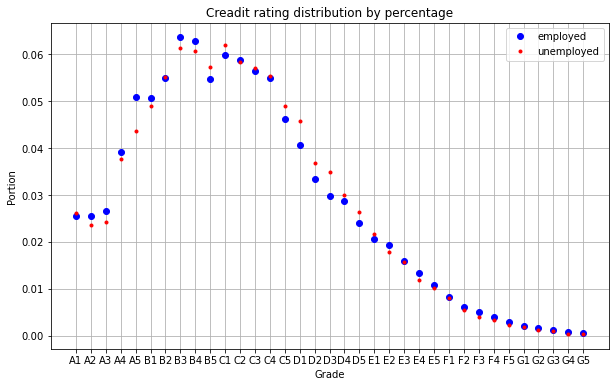

In [67]:
# credit rating distributions of the two groups
emp_grouped = df_filter_issue.groupby(['emp_cat', 'sub_grade']).size().reset_index()
emp_grouped.columns = ['emp_cat', 'sub_grade', 'count']
emp_grouped['percent'] = emp_grouped['count'] / emp_grouped.groupby('emp_cat')['count'].transform('sum')

print(emp_grouped)

x = emp_grouped['sub_grade'].unique()

plt.figure(figsize=(10,6))
plt.plot(x, emp_grouped[emp_grouped['emp_cat'] == 'employed']['percent'], 'bo', label='employed')
plt.plot(x, emp_grouped[emp_grouped['emp_cat'] == 'not_employed']['percent'], 'r.', label='unemployed')
plt.xlabel('Grade')
plt.ylabel('Portion')
plt.title('Creadit rating distribution by percentage')
plt.legend()
plt.grid(True)
plt.show()

Even though they have different average loan amounts, I found no other reasons to believe that the missing values can be interpreted as unemployment. So I imputed the data based on frequency.

/Users/llnormll/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


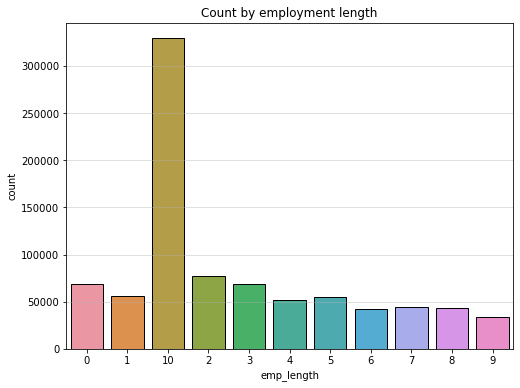

In [20]:
# fill with the most frequent data
most_frequent = df_filter_issue['emp_length'].value_counts().index[0]
df_filter_issue['emp_length'] = df_filter_issue['emp_length'].fillna(most_frequent)

# change data type from object to integer
df_filter_issue['emp_length'] = df_filter_issue['emp_length']
df_filter_issue = df_filter_issue.drop('emp_cat', axis=1)

# plot each value count
sns.countplot(df_filter_issue['emp_length'], order=np.sort(df_filter_issue['emp_length'].unique()), edgecolor='black')
plt.title('Count by employment length')
plt.grid(axis='y', alpha=.5)
plt.show()

> 1.5.2 `revol_util`

In [85]:
# filling with its average
avg_revol_util = np.mean(df_filter_issue['revol_util'])
df_filter_issue['revol_util'] = df_filter_issue['revol_util'].fillna(avg_revol_util)

## 2. Data Exploratory and Engineering

### 2.1 Basic statistics

In [86]:
df_filter_issue.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
funded_amnt,869592.0,14734.950097,8420.116413,500.00,8000.00,13000.000,20000.000000,3.500000e+04
int_rate,869592.0,13.261463,4.382156,5.32,9.99,12.990,16.200000,2.899000e+01
installment,869592.0,436.654689,243.959313,15.67,260.85,382.550,572.190000,1.445460e+03
dti,869592.0,18.130256,17.279049,0.00,11.90,17.630,23.910000,9.999000e+03
delinq_2yrs,869592.0,0.313753,0.861175,0.00,0.00,0.000,0.000000,3.900000e+01
inq_last_6mths,869592.0,0.695637,0.999936,0.00,0.00,0.000,1.000000,3.300000e+01
total_acc,869592.0,25.263911,11.831610,1.00,17.00,24.000,32.000000,1.690000e+02
pub_rec,869592.0,0.194285,0.580311,0.00,0.00,0.000,0.000000,8.600000e+01
revol_bal,869592.0,16912.122262,22421.677742,0.00,6451.00,11878.000,20821.000000,2.904836e+06
revol_util,869592.0,55.136001,23.814027,0.00,37.80,56.000,73.600000,8.923000e+02


### 2.2 Plot histograms

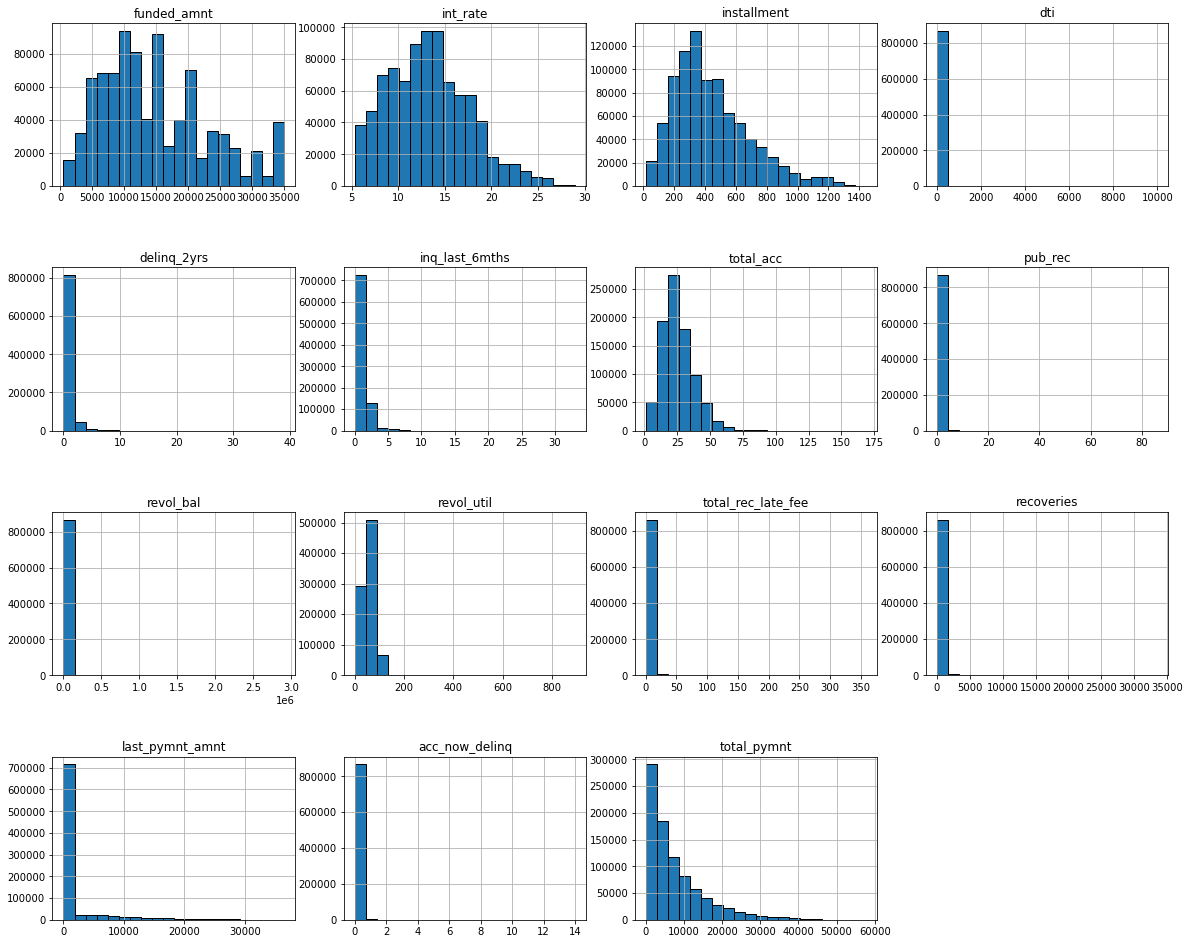

In [87]:
col_names = df_filter.select_dtypes(float).columns
n = len(col_names)

plt.figure(figsize=(20,30))
for i, col in enumerate(col_names):
    plt.subplot(int(n/2), 4, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    df_filter[col].hist(bins=20, edgecolor='black')
    plt.title(col)

There are a few data points with a reported `dti` (debt to monthly income ratio) of 9999.0. Having that much debt compared to one's montly income doesn't quite make sense to me, so I replaced it with a mean.

In [88]:
# replace it with the next largest value 
dti = df_filter_issue['dti']
dti_error = dti == 9999.0
dti[dti_error] = 672.52

print(df_filter_issue['dti'].max())

672.52


Also, the `revol_bal` and `recoveries` columns cover a wide range of their values. So took log to reduce it.

In [89]:
eps = 1e-3
for name in ['revol_bal', 'recoveries']:
    df_filter_issue['log_'+name] = np.log(df_filter_issue.pop(name)+eps)

### 2.3 Correlations

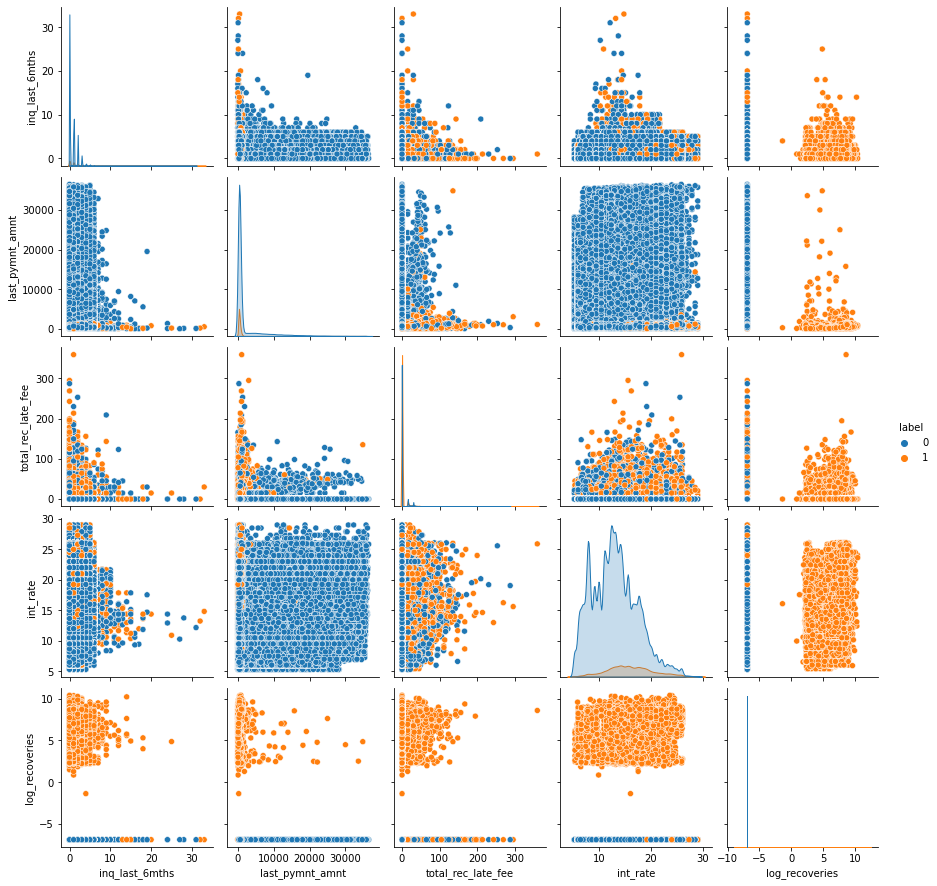

In [90]:
corr_df = df_filter_issue.corr()
cols_high_corr = abs(corr_df['label']).sort_values()[-6:].index.tolist()

# plot scatter matrix
sns.pairplot(df_filter_issue[cols_high_corr], diag_kind='kde', hue='label')
plt.show()

## 3. Initial modeling and evaluation


### 3.1 Data and model preparation

In [91]:
# remove date columns
df_modeling = df_filter_issue.drop(date_columns, axis=1)

df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869592 entries, 0 to 869639
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   funded_amnt         869592 non-null  float64
 1   term                869592 non-null  object 
 2   int_rate            869592 non-null  float64
 3   installment         869592 non-null  float64
 4   sub_grade           869592 non-null  object 
 5   emp_length          869592 non-null  object 
 6   home_ownership      869592 non-null  object 
 7   purpose             869592 non-null  object 
 8   dti                 869592 non-null  float64
 9   delinq_2yrs         869592 non-null  float64
 10  inq_last_6mths      869592 non-null  float64
 11  total_acc           869592 non-null  float64
 12  pub_rec             869592 non-null  float64
 13  revol_util          869592 non-null  float64
 14  total_rec_late_fee  869592 non-null  float64
 15  last_pymnt_amnt     869592 non-nul

In [92]:
# split dataset
train_df, test_df = train_test_split(df_modeling, test_size=0.2, stratify=df_modeling['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])

# labels
train_labels = np.array(train_df.pop('label'))
val_labels = np.array(val_df.pop('label'))
test_labels = np.array(test_df.pop('label'))

# features
train_features = train_df
val_features = val_df
test_features = test_df

In [93]:
# build a preprocessing pipeline
pipeline = ColumnTransformer([
     ('scaler', StandardScaler(), make_column_selector(dtype_exclude='object')),
     ('ordinal', OrdinalEncoder(), ['term', 'sub_grade', 'emp_length']),
     ('onehot', OneHotEncoder(), ['home_ownership', 'purpose'])
     ], remainder="passthrough")

train_features = pipeline.fit_transform(train_features)
val_features = pipeline.transform(val_features)
test_features = pipeline.transform(test_features)

(train_features.shape, val_features.shape, test_features.shape)

((556538, 36), (139135, 36), (173919, 36))

In [94]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS):
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    return model

In [95]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Add `class weight` to put more weights on the small positive samples.

In [10]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.54


### 3.2 Model training

In [97]:
model = make_model()

model_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight,
    verbose=0
    )

2022-01-12 22:57:19.761993: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-12 22:57:20.133553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 22:57:24.223829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 35.
Epoch 00045: early stopping


In [151]:
# plot learning metrics

def plot_metrics(history):
    plt.figure(figsize=(12,10))
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
    plt.legend()


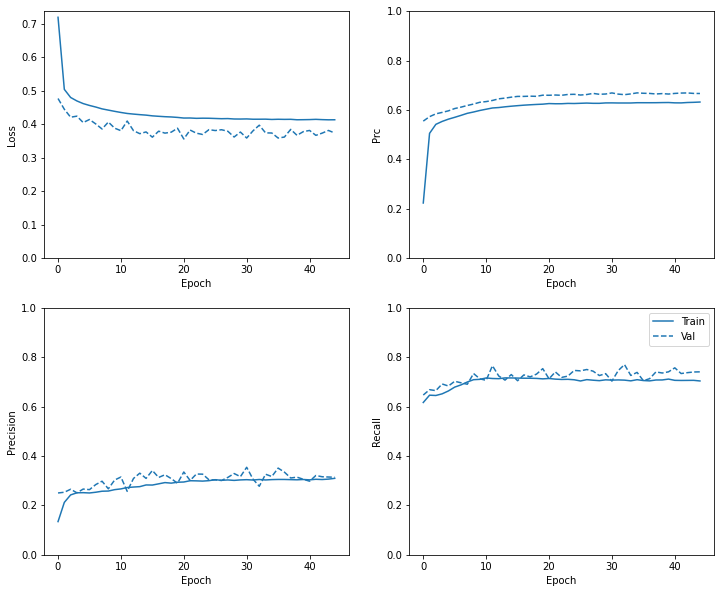

In [152]:
plot_metrics(model_history)

### 3.3 Model evaluation

In [129]:
# results output

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.19690798223018646
accuracy :  0.8989472389221191
precision :  0.42431753873825073
recall :  0.9010526537895203
auc :  0.9661746025085449
prc :  0.8246488571166992

Legitimate Transactions Detected (True Negatives):  144360
Legitimate Transactions Incorrectly Detected (False Positives):  16259
Fraudulent Transactions Missed (False Negatives):  1316
Fraudulent Transactions Detected (True Positives):  11984
Total Fraudulent Transactions:  13300


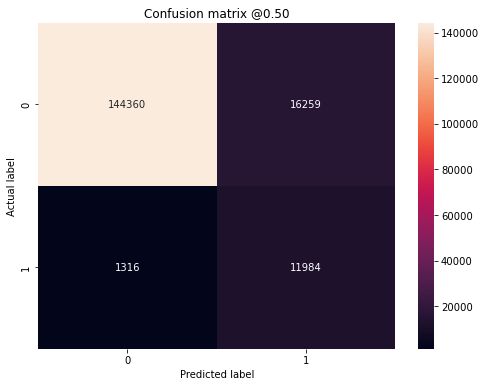

In [130]:
train_predictions_base = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_base = model.predict(test_features, batch_size=BATCH_SIZE)

evaluation = model.evaluate(test_features, test_labels, 
                            batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, evaluation):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_base)

I have achieved about 70% recall with this baseline model, which is not satisfactory. This is probably because some features like `recoveries` only happen to bad debts, their strong correlations with the label could be a result rather than a cause, possibly meaning they might not that benefitial when it comes to prediction. So, next thing I am going to do is to add more attributes that can be more related to behavioral aspects of borrowers(i.e., how they repay their loans).

## 4. Adding Features

Compare distributions of payment related features between the positive and negative samples.


/Users/llnormll/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/llnormll/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


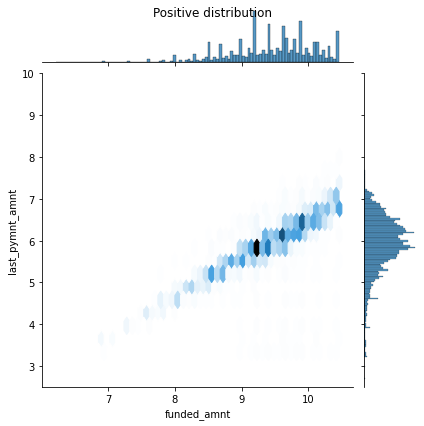

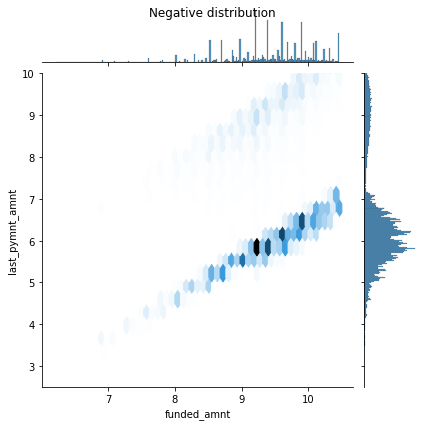

In [131]:
bool_labels = df_filter_issue['label'] != 0

pos_df = df_filter_issue[ bool_labels]
neg_df = df_filter_issue[~bool_labels]

sns.jointplot(np.log(pos_df['funded_amnt']+eps), np.log(pos_df['last_pymnt_amnt']+eps),
              kind='hex', ylim=(2.5,10))
plt.suptitle("Positive distribution")
sns.jointplot(np.log(neg_df['funded_amnt']+eps), np.log(neg_df['last_pymnt_amnt']+eps),
              kind='hex', ylim=(2.5,10))
_ = plt.suptitle("Negative distribution")

### 4.1 Overpayment

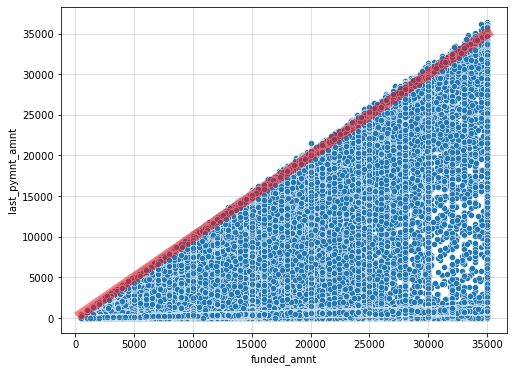

In [133]:
col = 'funded_amnt'

x1 = df_filter_issue[col].min()
x2 = df_filter_issue[col].max()

sns.scatterplot(x='funded_amnt', y='last_pymnt_amnt', data=df_filter_issue)
plt.plot([x1,x2], [x1,x2], color='red', lw=10, alpha=.5)
plt.grid(alpha=.5)
plt.show()

This is a scatterplot between `funded_amnt` and `last_pymnt_amnt` and the red straight line is `funded_amnt` = `funded_amnt`, meaning that some borrowers pay in lumpsum to repay their outstanding loans possibly for early repayment. Suppose good borrowers(who actively repay their loans) might be willing to repay amounts more than what they are scheduled to because they want to save interest costs. Comparing `last_pymnt_amnt` and `installment`(pre-calculated monthly payment schedule) might capture this overpayment trait of good borrowers.

In [104]:
df_filter_issue['overpay'] = df_filter_issue['last_pymnt_amnt'] - df_filter_issue['installment']

Another way to capture this overpayment.

In [105]:
# manually calculate a loan duration from issue date until last payment date in a monthly basis
df_filter_issue['duration'] = np.round((df_filter_issue['last_pymnt_d'] - df_filter_issue['issue_d']).dt.days / 31)

# calculate total sceduled payment 
total_scheduled_pay = df_filter_issue['installment'] * df_filter_issue['duration']

# calculate the payment gap between actual and scheduled 
df_filter_issue['pay_gap'] = df_filter_issue['total_pymnt'] - total_scheduled_pay

### 4.2 Overfunding

The next thing I wanted to see is how far each borrower's loan amount is from a median loan amount of each `purpose` category they belong to, hoping this might capture overfunding.

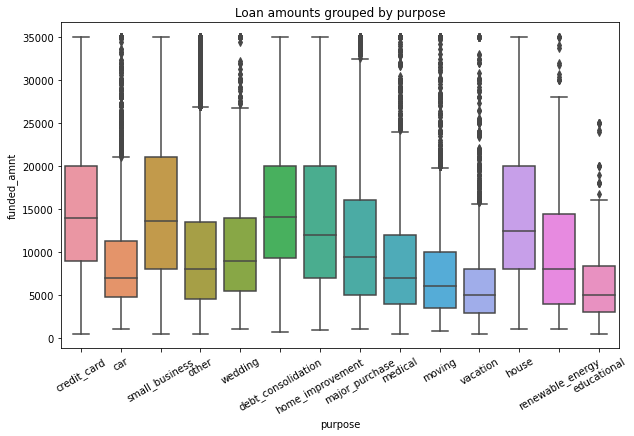

In [135]:
plt.figure(figsize=(10,6))
sns.boxplot(x='purpose', y='funded_amnt', data=df_filter_issue)
plt.xticks(rotation=30)
plt.title('Loan amounts grouped by purpose')
plt.show()

In [107]:
# calculate median loan amounts for each group in purpose category
purpose_median = dict(df_filter_issue.groupby('purpose')['funded_amnt'].median())
df_filter_issue['overfunding'] = df_filter_issue['funded_amnt'] - df_filter_issue['purpose'].map(purpose_median)

### 4.3 Credit events

The last thing I wanted to see is if there are borrowers whose official credit report was pulled after their last payment date. If so, it might indicate that they have applied for another loans or had some types of credit events/reports, all of which might affect their existing loan repayment.

In [108]:
# check if a borrower's credit was pulled by LC after one's last payment date
df_filter_issue['credit_pull_after_last_pay'] = (df_filter_issue['last_credit_pull_d'] - df_filter_issue['last_pymnt_d']).dt.days
df_filter_issue['credit_pull_after_last_pay'] = np.where(df_filter_issue['credit_pull_after_last_pay'] > 0, 1, 0)

### 4.4 Check correlations by label

Some added attributes show better correlations with the label. 

In [109]:
df_filter_issue.corr()['label'].sort_values(ascending=False)

label                         1.000000
log_recoveries                0.586058
credit_pull_after_last_pay    0.335304
int_rate                      0.175615
total_rec_late_fee            0.167444
inq_last_6mths                0.080646
revol_util                    0.050757
dti                           0.022799
installment                   0.014885
overfunding                   0.007966
duration                      0.004253
funded_amnt                   0.003727
delinq_2yrs                   0.002518
acc_now_delinq               -0.000053
pub_rec                      -0.013166
total_acc                    -0.017385
log_revol_bal                -0.019848
total_pymnt                  -0.045319
pay_gap                      -0.088100
last_pymnt_amnt              -0.103029
overpay                      -0.104933
Name: label, dtype: float64

## 5. Model Comparisons

### 5.1 Data and model preparation

In [110]:
df_modeling_improved = df_filter_issue.drop(date_columns, axis=1)

In [111]:
train_df, test_df = train_test_split(df_modeling_improved, test_size=0.2, stratify=df_modeling_improved['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])

train_labels = np.array(train_df.pop('label'))
val_labels = np.array(val_df.pop('label'))
test_labels = np.array(test_df.pop('label'))

train_features = train_df
val_features = val_df
test_features = test_df

train_features = pipeline.fit_transform(train_features)
val_features = pipeline.transform(val_features)
test_features = pipeline.transform(test_features)

### 5.2 Train and evaluate the model

In [112]:
model = make_model()

model_history_fa = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight
    )

Epoch 1/100


2022-01-12 23:05:01.657357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


272/272 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.7122 - precision: 0.1785 - recall: 0.7669 - auc: 0.8155 - prc: 0.3164

2022-01-12 23:05:06.279268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


272/272 [==============================] - 6s 19ms/step - loss: 0.6310 - accuracy: 0.7122 - precision: 0.1785 - recall: 0.7669 - auc: 0.8155 - prc: 0.3164 - val_loss: 0.3107 - val_accuracy: 0.8536 - val_precision: 0.3339 - val_recall: 0.9197 - val_auc: 0.9461 - val_prc: 0.7265
Epoch 2/100
272/272 [==============================] - 5s 17ms/step - loss: 0.3428 - accuracy: 0.8325 - precision: 0.2985 - recall: 0.8821 - auc: 0.9276 - prc: 0.6514 - val_loss: 0.2811 - val_accuracy: 0.8469 - val_precision: 0.3258 - val_recall: 0.9375 - val_auc: 0.9510 - val_prc: 0.7449
Epoch 3/100
272/272 [==============================] - 5s 18ms/step - loss: 0.3162 - accuracy: 0.8487 - precision: 0.3246 - recall: 0.9053 - auc: 0.9388 - prc: 0.6900 - val_loss: 0.2582 - val_accuracy: 0.8596 - val_precision: 0.3449 - val_recall: 0.9291 - val_auc: 0.9532 - val_prc: 0.7544
Epoch 4/100
272/272 [==============================] - 5s 17ms/step - loss: 0.3032 - accuracy: 0.8565 - precision: 0.3380 - recall: 0.9138 - a

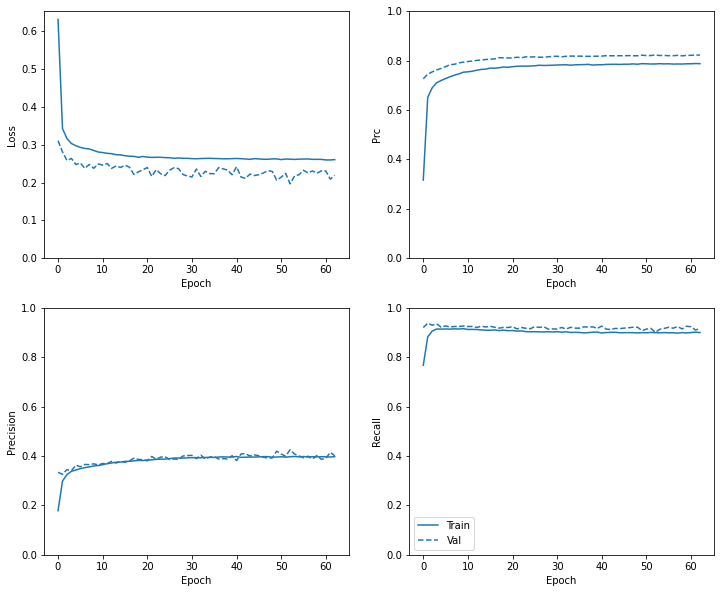

In [153]:
plot_metrics(model_history_fa)

loss :  0.19690798223018646
accuracy :  0.8989472389221191
precision :  0.42431753873825073
recall :  0.9010526537895203
auc :  0.9661746025085449
prc :  0.8246488571166992

Legitimate Transactions Detected (True Negatives):  144360
Legitimate Transactions Incorrectly Detected (False Positives):  16259
Fraudulent Transactions Missed (False Negatives):  1316
Fraudulent Transactions Detected (True Positives):  11984
Total Fraudulent Transactions:  13300


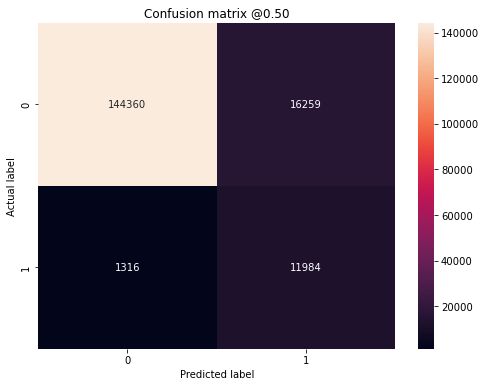

In [137]:
train_predictions_fa = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_fa = model.predict(test_features, batch_size=BATCH_SIZE)

evaluation = model.evaluate(test_features, test_labels, 
                            batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, evaluation):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_fa)

Overall, the model achieves better scores in every matrics. As a final step, I am going to tune some of keras's model hyperparameters.

### 5.3 Compare several models on different hyperparameters

In [141]:
def make_model(metrics=METRICS, 
               hidden_layer_sizes=hidden_layer_sizes, 
               dropout_rate=dropout_rate):
    model = Sequential()
    model.add(Input(shape=(train_features.shape[-1],)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense(hidden_layer_size, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model

In [142]:
hidden_layer_sizes = [(32,), (16,16,), (16,)]
dropout_rates = [0.5, 0.2]

names = []
scores = []
for dropout_rate in dropout_rates:
    for hidden_layer_size in hidden_layer_sizes:
        model = make_model(hidden_layer_sizes=hidden_layer_size, dropout_rate=dropout_rate)
        history = model.fit(
            train_features,
            train_labels,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[early_stopping],
            validation_data=(val_features, val_labels),
            class_weight=class_weight,
            verbose=0
            )
        eval = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
        scores.append(eval)

        name = str(hidden_layer_size) + '_' + str(dropout_rate)
        names.append(name)

scores_df = pd.DataFrame(scores, columns=model.metrics_names, index=names).transpose()

2022-01-12 23:21:10.399724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 23:21:14.140515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 74.
Epoch 00084: early stopping


2022-01-12 23:26:36.058916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 23:26:40.350921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 35.
Epoch 00045: early stopping


2022-01-12 23:29:54.214162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 23:29:58.095782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 43.
Epoch 00053: early stopping


2022-01-12 23:33:27.294937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 23:33:31.273899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 52.
Epoch 00062: early stopping


2022-01-12 23:37:49.691115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 23:37:55.194172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 25.
Epoch 00035: early stopping


2022-01-12 23:40:47.693518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 23:40:52.569417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [143]:
scores_df

,"(32,)_0.5","(16, 16)_0.5","(16,)_0.5","(32,)_0.2","(16, 16)_0.2","(16,)_0.2"
loss,0.215259,0.234414,0.210780,0.208539,0.219362,0.216324
accuracy,0.885648,0.884768,0.893795,0.888230,0.886177,0.888649
precision,0.394995,0.392237,0.411941,0.400454,0.395590,0.401641
recall,0.931654,0.922406,0.909398,0.928421,0.925263,0.931203
auc,0.969665,0.967341,0.965944,0.970399,0.969226,0.970394
prc,0.835171,0.829347,0.821482,0.839164,0.836593,0.835193


## 6. PySpark 

### 6.1 Data preprocessing

In [27]:
# load packages
from itertools import chain
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Normalizer
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [12]:
# define the schema datatype
schema = StructType([ \
    StructField("funded_amnt", DoubleType(),True), \
    StructField("term", StringType(),True), \
    StructField("int_rate", DoubleType(),True), \
    StructField("installment", DoubleType(),True), \
    StructField("sub_grade", StringType(),True), \
    StructField("emp_length", StringType(),True), \
    StructField("home_ownership", StringType(),True), \
    StructField("issue_d", DateType(),True), \
    StructField("loan_status", StringType(),True), \
    StructField("purpose", StringType(),True), \
    StructField("dti", DoubleType(),True), \
    StructField("delinq_2yrs", DoubleType(),True),
    StructField("earliest_cr_line", DateType(),True), \
    StructField("inq_last_6mths", DoubleType(),True), \
    StructField("total_acc", DoubleType(),True), \
    StructField("pub_rec", DoubleType(),True), \
    StructField("revol_bal", DoubleType(),True), \
    StructField("revol_util", DoubleType(),True), \
    StructField("total_rec_late_fee", DoubleType(),True), \
    StructField("recoveries", DoubleType(),True), \
    StructField("last_pymnt_d", DateType(),True), \
    StructField("last_pymnt_amnt", DoubleType(),True), \
    StructField("last_credit_pull_d", DateType(),True), \
    StructField("acc_now_delinq", DoubleType(),True), \
    StructField("total_pymnt", DoubleType(),True) \
  ])

In [13]:
appName = "credit_risk_analysis"
master = "local[*]"

spark = SparkSession.builder \
    .appName(appName) \
    .master(master) \
    .config('spark.sql.shuffle.partitions', 200) \
    .config('spark.debug.maxToStringFields', 100) \
    .config('spark.default.parallelism', 300) \
    .getOrCreate()

df_spark = spark.createDataFrame(df_filter, schema=schema)

22/01/18 14:23:25 WARN Utils: Your hostname, CHANGui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 172.30.1.56 instead (on interface en0)
22/01/18 14:23:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/18 14:23:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/01/18 14:23:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [14]:
# columns list except for dates
cols_except_date = [column.name for column in df_spark.schema.fields if "DateType" not in str(column.dataType)]

# check NaN or null values
df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols_except_date]).show()

+-----------+----+--------+-----------+---------+----------+--------------+-----------+-------+---+-----------+--------------+---------+-------+---------+----------+------------------+----------+---------------+--------------+-----------+
|funded_amnt|term|int_rate|installment|sub_grade|emp_length|home_ownership|loan_status|purpose|dti|delinq_2yrs|inq_last_6mths|total_acc|pub_rec|revol_bal|revol_util|total_rec_late_fee|recoveries|last_pymnt_amnt|acc_now_delinq|total_pymnt|
+-----------+----+--------+-----------+---------+----------+--------------+-----------+-------+---+-----------+--------------+---------+-------+---------+----------+------------------+----------+---------------+--------------+-----------+
|          0|   0|       0|          0|        0|     43602|             0|          0|      0|  0|          0|             0|        0|      0|        0|       459|                 0|         0|              0|             0|          0|
+-----------+----+--------+-----------+-----

In [15]:
# impute employment length with the most frequent value
emp_length = df_spark.groupby('emp_length').count().sort(col('count').desc())
emp_length.show()

most_frequent = emp_length.collect()[0][0]
df_spark = df_spark.replace("NaN", None)
df_spark_fill = df_spark.na.fill(most_frequent, subset='emp_length')

# impute revolve utilization rate with its average
df_spark_fill = df_spark_fill.fillna(df_filter['revol_util'].mean(), subset='revol_util')

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|285804|
|   2 years| 77388|
|  < 1 year| 68916|
|   3 years| 68630|
|    1 year| 55919|
|   5 years| 54594|
|   4 years| 51511|
|   7 years| 43970|
|       NaN| 43602|
|   8 years| 43070|
|   6 years| 42227|
|   9 years| 34009|
+----------+------+



In [16]:
# check if not null
df_spark_fill.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ['emp_length', 'revol_util']]).show()

+----------+----------+
|emp_length|revol_util|
+----------+----------+
|         0|         0|
+----------+----------+



In [17]:
# filter rows which label class is 'Issued'
df_spark_filter = df_spark_fill.filter(df_spark_fill.loan_status != 'Issued')

# convert labels into binary classes using UDF(user defined function) that I created earlier(at 1.3)
label_udf = udf(lambda x: classify_label(x), IntegerType())
df_spark_filter = df_spark_filter.withColumn('label', label_udf(df_spark_filter.loan_status))

df_spark_filter.select('label').distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



### 6.2 Add attributes

In [18]:
# overpayment
df_spark_filter = df_spark_filter.withColumn('overpay', col('last_pymnt_amnt') - col('installment'))
df_spark_filter.select('overpay').show(10)

+------------------+
|           overpay|
+------------------+
|              8.75|
|             59.83|
| 565.5799999999999|
|18.170000000000016|
|               0.0|
| 4.569999999999993|
|               0.0|
|1.9099999999999966|
|               0.0|
|               0.0|
+------------------+
only showing top 10 rows



In [19]:
# the payment gap between the actual payments vs. scheduled payment 

secondsToMonth = 60*60*24*31   # seconds to month

df_spark_adds = df_spark_filter.withColumn('issue_ts', to_timestamp(col('issue_d'))) \
                        .withColumn('last_pymnt_ts', to_timestamp(col('last_pymnt_d'))) \
                        .withColumn('duration', round((unix_timestamp('last_pymnt_ts')-unix_timestamp('issue_ts'))/secondsToMonth)) \
                        .withColumn('pay_gap', col('total_pymnt') - (col('duration')*col('installment')))

df_spark_adds.select(col('duration'), col('pay_gap')).show(10)

+--------+-------------------+
|duration|            pay_gap|
+--------+-------------------+
|    36.0|  -2.24858574999962|
|    16.0| 51.430000000000064|
|    29.0|  558.0836444499996|
|    36.0|   11.1422122999993|
|    48.0|             -11.75|
|    36.0| -1.182246820000728|
|    48.0|              -27.0|
|    36.0|-1.3356662400005916|
|     4.0| 36.460000000000036|
|    11.0|             140.24|
+--------+-------------------+
only showing top 10 rows



In [20]:
# credit event

condition = expr(
    """IF(credit_pull_after_last_pay > 0, 1, 0)"""
)

df_spark_adds = df_spark_adds \
                    .withColumn('last_credit_pull_ts', to_timestamp(col('last_credit_pull_d'))) \
                    .withColumn('credit_pull_after_last_pay', round((unix_timestamp('last_credit_pull_ts') - unix_timestamp('last_pymnt_ts'))/secondsToMonth)) \
                    .withColumn('credit_event', condition)

df_spark_adds.select(col('credit_pull_after_last_pay'), col('credit_event')).show(10)


+--------------------------+------------+
|credit_pull_after_last_pay|credit_event|
+--------------------------+------------+
|                      12.0|           1|
|                       5.0|           1|
|                      19.0|           1|
|                       0.0|           0|
|                       0.0|           0|
|                       8.0|           1|
|                       0.0|           0|
|                      -1.0|           0|
|                       4.0|           1|
|                       4.0|           1|
+--------------------------+------------+
only showing top 10 rows



In [21]:
# print data info
df_spark_adds.printSchema()

root
 |-- funded_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = false)
 |-- home_ownership: string (nullable = true)
 |-- issue_d: date (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- earliest_cr_line: date (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = false)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- last_pymnt_d: date (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- last_credit_pull_d: date (nullable = true)
 |-- acc_now_delinq: 

### 6.3 Model pipeline

In [40]:
# drop few columns that are no use in modeling

ts_columns = [column.name for column in df_spark_adds.schema.fields if "TimestampType" in str(column.dataType)]
columns_to_drop = date_columns + ts_columns + ['loan_status', 'credit_pull_after_last_pay']

df_spark_final = df_spark_adds.drop(*columns_to_drop)

In [41]:
features_num = [i.name for i in df_spark_final.schema.fields if "DoubleType" in str(i.dataType)]
features_cat = [i.name for i in df_spark_final.schema.fields if "StringType" in str(i.dataType)]

In [43]:
# add class weight to address the label classes imbalance
mapping_expr = create_map([lit(x) for x in chain(*class_weight.items())])
df_spark_final = df_spark_final.withColumn("weight", mapping_expr.getItem(col("label")))

df_spark_final.select(col('label'), col('weight')).show()

/Users/llnormll/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/pyspark/sql/column.py:322: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-----+------------------+
|label|            weight|
+-----+------------------+
|    0|0.5414011311253726|
|    1| 6.538482360371741|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    1| 6.538482360371741|
|    1| 6.538482360371741|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    1| 6.538482360371741|
|    0|0.5414011311253726|
|    1| 6.538482360371741|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
|    0|0.5414011311253726|
+-----+------------------+
only showing top 20 rows



In [44]:
# split train and test

splits = df_spark_final.randomSplit([0.8, 0.2])
df_train, df_test = splits[0], splits[1]

In [45]:
# build a pipeline

assembler1 = VectorAssembler(inputCols=features_num, outputCol="features")
normalizer = Normalizer(inputCol='features', outputCol='features_norm')

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in features_cat
]

# only 'home_ownership' and 'purpose' convert to one hot
encoders = [
    OneHotEncoder(inputCol=indexer.getOutputCol(), 
                  outputCol="{0}_encoded".format(indexer.getOutputCol()))
    for indexer in indexers[3:]
]

features_all = ["features_norm", "credit_event"] + [indexer.getOutputCol() for indexer in indexers[:3]] +\
               [encoder.getOutputCol() for encoder in encoders]
assembler2 = VectorAssembler(inputCols=features_all, outputCol="features_prepared")

gbt = GBTClassifier(labelCol="label", featuresCol="features_prepared", maxIter=10, maxBins=64, weightCol="weight")

In [46]:
pipeline = Pipeline(stages=[assembler1, normalizer]+indexers+encoders+[assembler2, gbt])

model = pipeline.fit(df_train)

In [47]:
prediction = model.transform(df_test)

prediction.select(col('probability'), col('prediction'), col('label')).show()

+--------------------+----------+-----+
|         probability|prediction|label|
+--------------------+----------+-----+
|[0.07785041527030...|       1.0|    1|
|[0.06718016159407...|       1.0|    1|
|[0.93682629440788...|       0.0|    0|
|[0.47092818015611...|       1.0|    0|
|[0.47092818015611...|       1.0|    0|
|[0.46516520076730...|       1.0|    0|
|[0.06739466923342...|       1.0|    1|
|[0.73774164454515...|       0.0|    0|
|[0.93932366957480...|       0.0|    0|
|[0.56285042539592...|       0.0|    1|
|[0.93183109419112...|       0.0|    0|
|[0.93410078401201...|       0.0|    0|
|[0.68187608630558...|       0.0|    0|
|[0.07788352692897...|       1.0|    1|
|[0.31152199143046...|       1.0|    0|
|[0.92130875942128...|       0.0|    0|
|[0.93410078401201...|       0.0|    0|
|[0.93410078401201...|       0.0|    0|
|[0.92750877595881...|       0.0|    0|
|[0.92696874765401...|       0.0|    0|
+--------------------+----------+-----+
only showing top 20 rows



In [48]:
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")
binEval.evaluate(prediction)

0.8647931491979255

In [49]:
y_true = prediction.select(col('label')).collect()
y_pred = prediction.select(col('prediction')).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    160592
           1       0.36      0.94      0.52     13519

    accuracy                           0.86    174111
   macro avg       0.68      0.90      0.72    174111
weighted avg       0.95      0.86      0.89    174111

